Results dir: assignment3_results
Dir 'cifar-10-batches-py' ok.
Loading CIFAR-10 from: cifar-10-batches-py
 Loading cifar-10-batches-py/data_batch_1...
 Loading cifar-10-batches-py/data_batch_2...
 Loading cifar-10-batches-py/data_batch_3...
 Loading cifar-10-batches-py/data_batch_4...
 Loading cifar-10-batches-py/data_batch_5...
Creating validation set (1000 samples)...
 Loading cifar-10-batches-py/test_batch...
Normalizing data (Train mean/std)...
Data loading complete.

Data shapes:
 Train:(3072, 49000), Val:(3072, 1000), Test:(3072, 10000)

#################### Conv Check ####################

--- Verifying Convolution Impl (NumPy vs PyTorch) ---
Conv Comparison (NumPy vs Torch): MaxAbsDiff=1.78e-15, MeanAbsDiff=1.30e-16
  MATCH.
----------------------------------

--- Verifying Convolution against debug_conv_info.npz ---
Loaded debug_info.npz: X((3072, 5)), Fs((4, 4, 3, 2)), Target((8, 8, 2, 5))
Comparison (order='C') Mine vs Target: MaxAbsDiff=2.66e-15, MeanAbsDiff=2.68e-16
Conv m

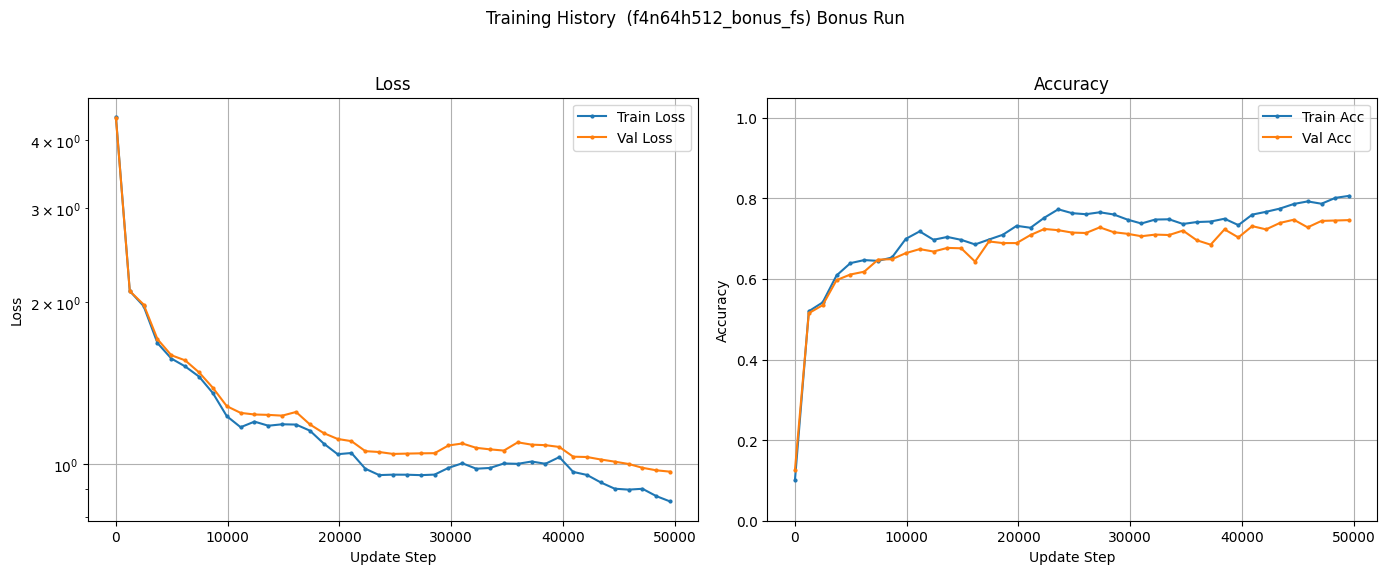

Congratulations! Achieved >= 70% accuracy! (+2 extra bonus points potential)

--- Assignment 3 Code Execution Complete ---


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import os
import sys # Needed for flushing output
import torch
import torch.nn.functional as F # Need this for functional conv2d and relu
import requests # For downloading data
import tarfile  # For extracting data
import shutil   # For moving directory if needed
import random   # Needed for data augmentation
import traceback # For detailed error printing

# --- tqdm (for progress bar) ---
try:
    from tqdm import tqdm
except ImportError:
    print("Optional dependency 'tqdm' not found. Progress bar will not be shown.")
    def tqdm(*args, **kwargs):
        if args:
            iterable = args[0]
            if 'desc' in kwargs: print(f"{kwargs['desc']}")
            for obj in iterable: yield obj
        return None

# --- Data Download Function ---
def download_and_extract_cifar10(data_dir="cifar-10-batches-py",
                                 url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                                 force_download=False):
    """Checks if CIFAR-10 data directory exists. If not, downloads and extracts."""
    filename = url.split('/')[-1]; extracted_internal_dir = "cifar-10-batches-py"
    if os.path.isdir(data_dir) and not force_download:
        req = [os.path.join(data_dir, f) for f in [f'data_batch_{i}' for i in range(1, 6)] + ['test_batch']]
        if all(os.path.exists(f) for f in req): print(f"Dir '{data_dir}' ok."); return True
        else: print(f"Warn: Dir '{data_dir}' missing files."); return True # Proceed cautiously
    if os.path.isdir(data_dir) and force_download:
        print(f"Force download enabled. Removing existing directory '{data_dir}'...")
        try: # <--- try 移到下一行并加冒号
            shutil.rmtree(data_dir) # <--- 这行缩进
        except OSError as e:
            print(f"Error removing existing directory: {e}. Please remove manually.") # <--- 这行也缩进
            return False
    print(f"Downloading '{filename}' from {url}...")
    try:
        resp = requests.get(url, stream=True, timeout=60); resp.raise_for_status()
        ts = int(resp.headers.get('content-length', 0)); bs = 1024 * 8
        with open(filename, 'wb') as f, tqdm(total=ts, unit='iB', unit_scale=True, desc=f"DL {filename}") as pb:
            for d in resp.iter_content(bs): s = f.write(d); pb.update(s)
        print("\nDL complete.")
    except requests.exceptions.RequestException as e: print(f"\nDL Error: {e}"); cleanup_download(filename); return False
    except Exception as e: print(f"\nDL Error: {e}"); cleanup_download(filename); return False
    print(f"Extracting '{filename}'..."); st = time.time()
    try:
        with tarfile.open(filename, "r:gz") as tar: tar.extractall(path=".")
        print(f"Extracted -> '{extracted_internal_dir}'.")
        if extracted_internal_dir != data_dir and not os.path.isdir(data_dir):
            print(f"Rename '{extracted_internal_dir}' -> '{data_dir}'..."); shutil.move(extracted_internal_dir, data_dir); print("Renamed.")
        print(f"Extracted in {time.time() - st:.2f}s.")
    except tarfile.TarError as e: print(f"\nExtract Error: {e}"); cleanup_extracted(extracted_internal_dir); return False
    except Exception as e: print(f"\nExtract Error: {e}"); cleanup_extracted(extracted_internal_dir); return False
    finally: cleanup_download(filename)
    if os.path.isdir(data_dir): print(f"Data ready: '{data_dir}'."); return True
    else: print(f"Error: Target dir '{data_dir}' not found."); return False

def cleanup_download(filepath):
    if os.path.exists(filepath):
        try: # <--- 移到下一行并加冒号
            os.remove(filepath) # <--- 缩进
            print(f"Cleaned up {filepath}") # <--- 缩进
        except OSError as e:
            print(f"Error cleaning up {filepath}: {e}") # <--- 缩进
def cleanup_extracted(dirpath):
     if os.path.exists(dirpath):
        try: # <--- 移到下一行并加冒号
            shutil.rmtree(dirpath) # <--- 缩进
            print(f"Cleaned up extracted dir {dirpath}") # <--- 缩进
        except OSError as e:
            print(f"Error cleaning up extracted dir {dirpath}: {e}") # <--- 缩进

# --- Data Loading and Preprocessing ---
def unpickle(file):
    with open(file, 'rb') as fo: return pickle.load(fo, encoding='bytes')
def load_cifar10_batch(filename):
    if not os.path.exists(filename): raise FileNotFoundError(filename)
    d = unpickle(filename); X = d[b'data'].T / 255.0; y = np.array(d[b'labels']); Y = np.eye(10)[y].T
    return X, Y, y
def load_cifar10_data(data_dir):
    print(f"Loading CIFAR-10 from: {data_dir}")
    if not os.path.isdir(data_dir): raise NotADirectoryError(data_dir)
    Xt, Yt, yt = [], [], []; n_val = 1000
    for i in range(1, 6):
        fn = os.path.join(data_dir, f'data_batch_{i}'); print(f" Loading {fn}...")
        Xb, Yb, yb = load_cifar10_batch(fn); Xt.append(Xb); Yt.append(Yb); yt.append(yb)
    X_tr_all = np.concatenate(Xt, axis=1); Y_tr_all = np.concatenate(Yt, axis=1); y_tr_all = np.concatenate(yt)
    assert X_tr_all.shape[1] > n_val, "Not enough data for validation split"
    print(f"Creating validation set ({n_val} samples)...")
    X_v = X_tr_all[:, -n_val:]; Y_v = Y_tr_all[:, -n_val:]; y_v = y_tr_all[-n_val:]
    X_tr = X_tr_all[:, :-n_val]; Y_tr = Y_tr_all[:, :-n_val]; y_tr = y_tr_all[:-n_val]
    fn_te = os.path.join(data_dir, 'test_batch'); print(f" Loading {fn_te}...")
    X_te, Y_te, y_te = load_cifar10_batch(fn_te)
    print("Normalizing data (Train mean/std)...")
    mean_X = np.mean(X_tr, axis=1, keepdims=True); std_X = np.std(X_tr, axis=1, keepdims=True)
    X_tr = (X_tr - mean_X) / std_X; X_v = (X_v - mean_X) / std_X; X_te = (X_te - mean_X) / std_X
    dtype = np.float32; X_tr=X_tr.astype(dtype); Y_tr=Y_tr.astype(dtype); y_tr=y_tr # Keep y as int
    X_v=X_v.astype(dtype); Y_v=Y_v.astype(dtype); y_v=y_v
    X_te=X_te.astype(dtype); Y_te=Y_te.astype(dtype); y_te=y_te
    print("Data loading complete.")
    return (X_tr, Y_tr, y_tr), (X_v, Y_v, y_v), (X_te, Y_te, y_te)

# --- Utility Functions ---
def reshape_to_images(X_flat, n):
    d = X_flat.shape[0]; assert d==3072; assert X_flat.shape[1]==n
    dtype = np.float64 if n <= 10 else np.float32; X_t = X_flat.T.astype(dtype)
    X_ims_nchw = X_t.reshape(n, 3, 32, 32); return np.transpose(X_ims_nchw, (2, 3, 1, 0)) # HWCN
def compute_MX(X_flat, f, n):
    is_check = n <= 10; dtype = np.float64 if is_check else np.float32
    if not is_check and n > 500: print(f"Computing MX f={f},n={n}...", end=' ', flush=True)
    start_time = time.time(); X_ims = reshape_to_images(X_flat, n)
    img_h,img_w,img_c,num_imgs = X_ims.shape; assert img_c==3; stride = f
    assert img_h%stride==0 and img_w%stride==0, f"Stride {f}!"
    np_h,np_w=img_h//stride,img_w//stride; num_patches=np_h*np_w; patch_dim=f*f*img_c
    MX = np.zeros((num_patches, patch_dim, num_imgs), dtype=dtype); patch_idx = 0
    patch_row_buffer = np.zeros((patch_dim,), dtype=dtype)
    for r in range(np_h):
        for c in range(np_w):
            r_s,r_e=r*stride,(r+1)*stride; c_s,c_e=c*stride,(c+1)*stride
            X_patch_all_imgs = X_ims[r_s:r_e, c_s:c_e, :, :]
            for img_idx in range(num_imgs):
                current_pos = 0
                for ch in range(img_c):
                    flattened_ch = X_patch_all_imgs[:, :, ch, img_idx].flatten(order='C')
                    patch_row_buffer[current_pos : current_pos + f*f] = flattened_ch
                    current_pos += f*f
                MX[patch_idx, :, img_idx] = patch_row_buffer
            patch_idx += 1
    end_time = time.time()
    if not is_check and n > 500: print(f"Done ({end_time - start_time:.2f}s)")
    return MX
def get_mx_batch(MX_full, indices): return MX_full[:, :, indices]

# --- Data Augmentation ---
def augment_batch_flip(X_batch):
    n_batch = X_batch.shape[1]; X_imgs_t = X_batch.T.reshape(n_batch, 3, 32, 32)
    X_augmented = X_imgs_t.copy()
    for i in range(n_batch):
        if random.random() < 0.5: X_augmented[i, :, :, :] = X_augmented[i, :, :, ::-1]
    return X_augmented.reshape(n_batch, 3072).T
def augment_batch_shift(X_batch, pad=4):
    n_batch = X_batch.shape[1]; X_imgs_t = X_batch.T.reshape(n_batch, 3, 32, 32)
    h_orig, w_orig = 32, 32
    padded_imgs = np.pad(X_imgs_t, ((0,0),(0,0),(pad,pad),(pad,pad)), mode='constant')
    augmented_imgs = np.zeros_like(X_imgs_t)
    for i in range(n_batch):
        h_start = random.randint(0, 2 * pad); w_start = random.randint(0, 2 * pad)
        augmented_imgs[i,:,:,:] = padded_imgs[i, :, h_start:h_start+h_orig, w_start:w_start+w_orig]
    return augmented_imgs.reshape(n_batch, 3072).T

# --- Network Initialization ---
def initialize_parameters_he(f, nf, nh, K, seed=42):
    np.random.seed(seed); dtype = np.float32; assert 32%f==0
    np_h,np_w = 32//f,32//f; num_patches=np_h*np_w; d0=num_patches*nf; patch_dim=f*f*3
    std_c=np.sqrt(2./patch_dim); bc=np.zeros((nf,1),dtype=dtype)
    std_1=np.sqrt(2./d0); W1=np.random.normal(0,std_1,(nh,d0)).astype(dtype); b1=np.zeros((nh,1),dtype=dtype)
    std_2=np.sqrt(2./nh); W2=np.random.normal(0,std_2,(K,nh)).astype(dtype); b2=np.zeros((K,1),dtype=dtype)
    Fs_flat = np.zeros((patch_dim, nf), dtype=dtype); filter_buffer = np.zeros((patch_dim,), dtype=dtype)
    for k in range(nf):
        filter_k_spatial = np.random.normal(0, std_c, (f, f, 3)).astype(dtype); current_pos = 0
        for ch in range(3):
            flattened_ch = filter_k_spatial[:, :, ch].flatten(order='C')
            filter_buffer[current_pos : current_pos + f*f] = flattened_ch; current_pos += f*f
        Fs_flat[:, k] = filter_buffer
    return {'Fs_flat':Fs_flat,'b_conv':bc,'W1':W1,'b1':b1,'W2':W2,'b2':b2}

# --- Activation and Loss ---
def softmax(s): p=np.exp(s-np.max(s,axis=0,keepdims=True)); p/=(np.sum(p,axis=0,keepdims=True)+1e-9); return p
def compute_cost(P, Y_batch, params, lamda):
    n_batch = Y_batch.shape[1]; assert n_batch > 0
    log_p = np.log(P+1e-9); cross_entropy=-np.sum(Y_batch*log_p)/n_batch
    l2 = np.sum(params['Fs_flat']**2)+np.sum(params['W1']**2)+np.sum(params['W2']**2)
    return cross_entropy + (lamda/2.0)*l2
def compute_accuracy(P, y_cls): return np.mean(np.argmax(P,axis=0)==y_cls) if P.size>0 else 0.0

# --- Forward and Backward Pass ---
def evaluate_classifier(MX_batch, params):
    Fs_flat=params['Fs_flat']; b_conv=params['b_conv']; W1=params['W1']; b1=params['b1']; W2=params['W2']; b2=params['b2']
    np_val,_,n_batch = MX_batch.shape; nf=Fs_flat.shape[1]; d0=W1.shape[1]; assert np_val*nf == d0
    conv_out = np.einsum('ijn,jl->iln',MX_batch,Fs_flat,optimize=True) + b_conv.reshape(1,nf,1)
    H_raw=np.fmax(conv_out,0); h=H_raw.reshape((d0,n_batch),order='F')
    s1=W1@h+b1; x1=np.fmax(s1,0); s=W2@x1+b2; P=softmax(s)
    cache = {'MX_batch':MX_batch,'conv_outputs_mat':conv_out,'H_raw':H_raw,'h':h,'s1':s1,'x1':x1,'s':s}
    return P, cache
def compute_gradients(P, Y_target, params, cache, lamda):
    n_batch = Y_target.shape[1]; K = Y_target.shape[0]; nh = params['W1'].shape[0]; nf = params['b_conv'].shape[0]
    np_val = cache['H_raw'].shape[0]; d0 = params['W1'].shape[1]; assert np_val*nf==d0
    patch_dim = params['Fs_flat'].shape[0]; G = P - Y_target
    grad_W2 = (1/n_batch)*(G @ cache['x1'].T) + lamda*params['W2']
    grad_b2 = (1/n_batch)*np.sum(G, axis=1, keepdims=True)
    G = params['W2'].T @ G; G = G * (cache['s1'] > 0)
    grad_W1 = (1/n_batch)*(G @ cache['h'].T) + lamda*params['W1']
    grad_b1 = (1/n_batch)*np.sum(G, axis=1, keepdims=True)
    G = params['W1'].T @ G; G_r = G.reshape((np_val, nf, n_batch), order='F')
    GG = G_r * (cache['conv_outputs_mat'] > 0)
    grad_b_conv = (1/n_batch)*np.sum(GG, axis=(0, 2)).reshape(nf, 1)
    MXt = np.transpose(cache['MX_batch'], (1, 0, 2))
    grad_Fs_flat = (1/n_batch)*np.einsum('ijn,jln->il', MXt, GG, optimize=True) + lamda*params['Fs_flat']
    grads = {'Fs_flat': grad_Fs_flat, 'b_conv': grad_b_conv, 'W1': grad_W1, 'b1': grad_b1, 'W2': grad_W2, 'b2': grad_b2}
    return grads

# --- PyTorch Gradients for Comparison ---
def ComputeGradsWithTorch_ConvNet(X_flat_batch, Y_batch, params, f, lamda=0.0, compare_intermediates=True):
    n_batch = X_flat_batch.shape[1]; K = Y_batch.shape[0]; dtype = torch.double
    X_t = torch.from_numpy(X_flat_batch).T.reshape(n_batch, 3, 32, 32).to(dtype)
    y_c = torch.from_numpy(np.argmax(Y_batch, axis=0)).long()
    Fs_flat_t = torch.tensor(params['Fs_flat'], requires_grad=True, dtype=dtype)
    b_conv_t = torch.tensor(params['b_conv'], requires_grad=True, dtype=dtype)
    W1_t = torch.tensor(params['W1'], requires_grad=True, dtype=dtype)
    b1_t = torch.tensor(params['b1'], requires_grad=True, dtype=dtype)
    W2_t = torch.tensor(params['W2'], requires_grad=True, dtype=dtype)
    b2_t = torch.tensor(params['b2'], requires_grad=True, dtype=dtype)
    nf = b_conv_t.shape[0]; patch_dim = Fs_flat_t.shape[0]; nh = W1_t.shape[0]; d0 = W1_t.shape[1]
    Fs_torch_conv = Fs_flat_t.T.reshape(nf, 3, f, f).contiguous()
    b_conv_torch_flat=b_conv_t.flatten(); b1_torch_flat=b1_t.flatten(); b2_torch_flat=b2_t.flatten()
    conv_o = F.conv2d(X_t, Fs_torch_conv, bias=b_conv_torch_flat, stride=f, padding=0)
    h_raw_t = F.relu(conv_o); h_f = h_raw_t.reshape(n_batch, -1); assert h_f.shape[1] == d0
    s1_t = F.linear(h_f, W1_t, bias=b1_torch_flat); x1_t = F.relu(s1_t)
    s_t = F.linear(x1_t, W2_t, bias=b2_torch_flat)
    if compare_intermediates:
        print("\n--- Comparing Intermediates ---")
        try:
            p_np64 = {k: v.astype(np.float64) for k, v in params.items()}
            MX_c = compute_MX(X_flat_batch.astype(np.float64), f, n_batch)
            _, cache_a = evaluate_classifier(MX_c, p_np64); np_h, np_w = 32 // f, 32 // f
            conv_np = cache_a['conv_outputs_mat']
            conv_np_reshaped_torch_order = conv_np.reshape((np_h,np_w,nf,n_batch), order='C').transpose(3,2,0,1)
            conv_np_t = torch.from_numpy(conv_np_reshaped_torch_order).to(dtype)
            max_d = torch.max(torch.abs(conv_o - conv_np_t)).item(); print(f"ConvOut MaxDiff:{max_d:.2e}")
            h_np = cache_a['h'].T; max_d = torch.max(torch.abs(h_f - torch.from_numpy(h_np).to(dtype))).item(); print(f"h_flat MaxDiff:{max_d:.2e}")
            s1_np = cache_a['s1'].T; max_d = torch.max(torch.abs(s1_t - torch.from_numpy(s1_np).to(dtype))).item(); print(f"s1 MaxDiff:{max_d:.2e}")
            x1_np = cache_a['x1'].T; max_d = torch.max(torch.abs(x1_t - torch.from_numpy(x1_np).to(dtype))).item(); print(f"x1 MaxDiff:{max_d:.2e}")
            s_np = cache_a['s'].T; max_d = torch.max(torch.abs(s_t - torch.from_numpy(s_np).to(dtype))).item(); print(f"s MaxDiff:{max_d:.2e}")
            print("-" * 29)
        except Exception as e: print(f"Error intermediate check: {e}"); traceback.print_exc()
    loss_ce = F.cross_entropy(s_t, y_c)
    l2 = torch.sum(Fs_flat_t**2) + torch.sum(W1_t**2) + torch.sum(W2_t**2)
    loss = loss_ce + (lamda / 2.) * l2; loss.backward()
    grads_t = {}; dtype_out = np.float32
    if Fs_flat_t.grad is not None: grads_t['Fs_flat']=Fs_flat_t.grad.numpy().astype(dtype_out)
    if b_conv_t.grad is not None: grads_t['b_conv']=b_conv_t.grad.numpy().astype(dtype_out)
    if W1_t.grad is not None: grads_t['W1']=W1_t.grad.numpy().astype(dtype_out)
    if b1_t.grad is not None: grads_t['b1']=b1_t.grad.numpy().astype(dtype_out)
    if W2_t.grad is not None: grads_t['W2']=W2_t.grad.numpy().astype(dtype_out)
    if b2_t.grad is not None: grads_t['b2']=b2_t.grad.numpy().astype(dtype_out)
    exp_k={'Fs_flat','b_conv','W1','b1','W2','b2'}
    if set(grads_t.keys()) != exp_k: print(f"Warn: Missing grads. Found: {grads_t.keys()}")
    return grads_t

def compare_gradients(analytic_grads, torch_grads, tolerance=1e-5, verbose=False):
    print("\n--- Comparing Gradients ---"); max_err = 0.; passed = True
    ana_k = set(analytic_grads.keys()); tor_k = set(torch_grads.keys())
    if ana_k != tor_k: print(f"ERROR: Key mismatch! Ana={ana_k}, Tor={tor_k}"); return False
    for key in analytic_grads.keys():
        ana_g = analytic_grads[key]; tor_g = torch_grads.get(key)
        if tor_g is None: print(f"ERROR: Missing torch grad for '{key}'"); passed = False; continue
        if ana_g.shape != tor_g.shape: print(f"Shape mismatch '{key}': Ana={ana_g.shape}, Tor={tor_g.shape}"); passed = False; continue
        eps = 1e-9; diff = np.abs(ana_g - tor_g); denom = np.maximum(np.abs(ana_g) + np.abs(tor_g), eps)
        rel_err = diff / denom; max_rel = np.max(rel_err); max_err = max(max_err, max_rel)
        print(f"'{key}' ({ana_g.shape}). MaxRelErr: {max_rel:.2e}")
        if max_rel > tolerance: print(f"  **** HIGH ERROR ****"); passed = False
        sys.stdout.flush()
    print(f"\n--- Comparison Summary --- Max overall error: {max_err:.2e}")
    result = passed and max_err <= tolerance; print("PASSED." if result else "FAILED."); print("-" * 26)
    return result

# --- Convolution Implementation Check (NumPy vs PyTorch) ---
def check_convolution_implementation(X_flat_batch, params, f):
    print("\n--- Verifying Convolution Impl (NumPy vs PyTorch) ---")
    n_batch = X_flat_batch.shape[1]; dtype = torch.double; dtype_np = np.float64
    p_np = {k: v.astype(dtype_np) for k, v in params.items()}
    X_np = X_flat_batch.astype(dtype_np)
    MX_np = compute_MX(X_np, f, n_batch); Fs_f_np = p_np['Fs_flat']
    bc_np = p_np['b_conv']; nf = p_np['b_conv'].shape[0]
    conv_np_einsum = np.einsum('ijn,jl->iln', MX_np, Fs_f_np, optimize=True) + bc_np.reshape(1, nf, 1)
    X_t = torch.from_numpy(X_np).T.reshape(n_batch, 3, 32, 32).to(dtype)
    Fs_t = torch.tensor(Fs_f_np.T.reshape(nf, 3, f, f), dtype=dtype)
    bc_t = torch.tensor(bc_np.flatten(), dtype=dtype)
    conv_t = F.conv2d(X_t, Fs_t, bias=bc_t, stride=f, padding=0)
    np_h, np_w = 32 // f, 32 // f; result = False
    try:
        # Use order='C' based on previous findings for debug_info.npz matching
        conv_np_reshaped_torch_order = conv_np_einsum.reshape((np_h,np_w,nf,n_batch), order='C').transpose(3,2,0,1)
        conv_np_torch_tensor = torch.from_numpy(conv_np_reshaped_torch_order).to(dtype)
        max_d = torch.max(torch.abs(conv_t - conv_np_torch_tensor)).item()
        mean_d = torch.mean(torch.abs(conv_t - conv_np_torch_tensor)).item()
        print(f"Conv Comparison (NumPy vs Torch): MaxAbsDiff={max_d:.2e}, MeanAbsDiff={mean_d:.2e}")
        result = max_d < 1e-7; print("  MATCH." if result else "  MISMATCH.")
    except Exception as e: print(f"Error during NumPy vs Torch conv comparison: {e}")
    finally: print("-" * 34)
    return result

# --- Training Loop (Modified for Bonus) ---
def mini_batch_gd(X_train, Y_train, y_train, X_val, Y_val, y_val,
                   MX_train_full, MX_val_full, params, f, # MX_train_full used for metrics
                   n_batch=100, eta_min=1e-5, eta_max=1e-1, n_s=800,
                   n_cycles=3, lamda=0.003, update_scheme='standard',
                   initial_step_size=800, track_metrics=True, metrics_interval_factor=10,
                   use_label_smoothing=False, epsilon=0.1,
                   # --- Bonus parameters ---
                   use_augmentation=False,
                   augment_flip=False, # Control flip specifically
                   augment_shift=False, # Control shift specifically
                   shift_pad=4,         # Padding for shift
                   eta_decay_factor=1.0):
    """ Performs mini-batch gradient descent training. """
    n = X_train.shape[1]; current_params = params.copy()
    K = Y_train.shape[0]
    current_eta_max = eta_max
    print(f"Initial eta_max: {current_eta_max:.4f}, Decay factor: {eta_decay_factor:.2f}")
    augmentation_enabled = []
    if use_augmentation and augment_flip: augmentation_enabled.append("Flip")
    if use_augmentation and augment_shift: augmentation_enabled.append(f"Shift(Pad={shift_pad})")
    if augmentation_enabled: print(f"Data Augmentation: Enabled ({', '.join(augmentation_enabled)})")
    else: print("Data Augmentation: Disabled")
    if update_scheme == 'standard': total_updates = 2 * n_s * n_cycles; print(f"Standard CLR: n_s={n_s}")
    elif update_scheme == 'increasing_step': total_updates = sum(2*initial_step_size*(2**c) for c in range(n_cycles)); steps=[initial_step_size*(2**c) for c in range(n_cycles)]; print(f"Increasing CLR: init_n_s={initial_step_size}, steps={steps}")
    else: raise ValueError("Invalid update scheme")
    print(f" n_b={n_batch}, eta=[{eta_min:.1e},{current_eta_max:.1e}], cyc={n_cycles}, lam={lamda}, upd={total_updates}, LS={use_label_smoothing}")
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'eta': [], 'update_step': []}
    t_start = time.time(); cycle = 0; t_cyc = 0
    curr_ns = initial_step_size if update_scheme == 'increasing_step' else n_s
    log_int = max(1, total_updates // metrics_interval_factor) if track_metrics else total_updates + 1; print(f"Log every {log_int} steps.")
    Y_train_smooth = None
    if use_label_smoothing:
        print(f"Using Label Smoothing with epsilon={epsilon}")
        Y_train_smooth = np.full(Y_train.shape, epsilon / (K - 1), dtype=Y_train.dtype)
        true_classes = np.argmax(Y_train, axis=0)
        Y_train_smooth[true_classes, np.arange(n)] = 1.0 - epsilon
        print(f"Smoothed labels computed. Shape: {Y_train_smooth.shape}")
    try:
        for step in range(total_updates):
            prev_cycle = cycle
            if update_scheme == 'standard':
                t = step % (2 * curr_ns); current_cycle = step // (2 * curr_ns)
                if current_cycle > cycle and eta_decay_factor < 1.0:
                    cycle = current_cycle; current_eta_max *= eta_decay_factor
                    print(f"\nNew cycle {cycle + 1}, eta_max decayed to {current_eta_max:.4f}")
                eta = eta_min + (t/curr_ns)*(current_eta_max-eta_min) if t<curr_ns else current_eta_max-((t-curr_ns)/curr_ns)*(current_eta_max-eta_min)
            else:
                if t_cyc >= 2 * curr_ns:
                    cycle += 1; print(f"\nCompleted cycle {cycle}/{n_cycles}.")
                    if cycle >= n_cycles: print("Target cycles reached."); break
                    if eta_decay_factor < 1.0:
                        current_eta_max *= eta_decay_factor
                        print(f"New cycle {cycle+1}, eta_max decayed to {current_eta_max:.4f}")
                    curr_ns = initial_step_size * (2**cycle); t_cyc = 0
                    print(f"Starting cycle {cycle + 1}/{n_cycles} with n_s = {curr_ns}")
                eta = eta_min + (t_cyc/curr_ns)*(current_eta_max-eta_min) if t_cyc<curr_ns else current_eta_max-((t_cyc-curr_ns)/curr_ns)*(current_eta_max-eta_min)
                t_cyc += 1
            idxs = np.random.choice(n, n_batch, replace=False); X_batch_current = X_train[:, idxs]
            if use_augmentation:
                if augment_flip: X_batch_current = augment_batch_flip(X_batch_current)
                if augment_shift: X_batch_current = augment_batch_shift(X_batch_current, pad=shift_pad)
                MX_b = compute_MX(X_batch_current.astype(np.float32), f, n_batch)
            else: MX_b = get_mx_batch(MX_train_full, idxs)
            if use_label_smoothing: Y_target_batch = Y_train_smooth[:, idxs]
            else: Y_target_batch = Y_train[:, idxs]
            P, cache = evaluate_classifier(MX_b, current_params)
            grads = compute_gradients(P, Y_target_batch, current_params, cache, lamda)
            for k in current_params:
                if k in grads:
                    if np.any(np.isnan(grads[k])) or np.any(np.isinf(grads[k])): raise ValueError(f"NaN/Inf grad '{k}' step {step}")
                    current_params[k] -= eta * grads[k]
            if track_metrics and (step % log_int == 0 or step == total_updates - 1):
                try:
                    sub_n=min(5000,n); sub_i=np.random.choice(n,sub_n,replace=False); MX_sub=get_mx_batch(MX_train_full,sub_i)
                    P_sub,_=evaluate_classifier(MX_sub,current_params); tr_l=compute_cost(P_sub, Y_train[:, sub_i], current_params, lamda); tr_a=compute_accuracy(P_sub, y_train[sub_i])
                    P_v,_=evaluate_classifier(MX_val_full,current_params); va_l=compute_cost(P_v, Y_val, current_params, lamda); va_a=compute_accuracy(P_v, y_val)
                    history['train_loss'].append(tr_l); history['val_loss'].append(va_l); history['train_acc'].append(tr_a); history['val_acc'].append(va_a); history['eta'].append(eta); history['update_step'].append(step)
                    elapsed = time.time() - t_start; print(f" Upd:{step}/{total_updates},T:{elapsed:.1f}s,Eta:{eta:.1e},LRmax:{current_eta_max:.1e},TrL:{tr_l:.3f},VlL:{va_l:.3f},VlAcc:{va_a:.3f}"); sys.stdout.flush()
                except Exception as me: print(f"\nWarn: Metric err step {step}: {me}")
            elif step % 500 == 0 and not track_metrics: print(f" Upd:{step}...", end=' '); sys.stdout.flush()
    except KeyboardInterrupt: print("\nTraining Interrupted.")
    except ValueError as ve: print(f"\nStopping: {ve}")
    finally: t_tot = time.time() - t_start; print(f"Ended after {t_tot:.2f}s.")
    return current_params, history, t_tot

def plot_loss_acc(history, title_suffix="", save_path=None):
    if not history or not history.get('update_step'): print("No plot data."); return
    fig, axs = plt.subplots(1, 2, figsize=(14, 6)); fig.suptitle(f"Training History {title_suffix}")
    # Loss Plot
    axs[0].plot(history['update_step'], history['train_loss'], label='Train Loss', marker='.', markersize=4)
    axs[0].plot(history['update_step'], history['val_loss'], label='Val Loss', marker='.', markersize=4)
    axs[0].set_xlabel('Update Step'); axs[0].set_ylabel('Loss'); axs[0].set_title('Loss'); axs[0].legend(); axs[0].grid(True)
    try: min_loss=min(min(history.get('train_loss',[1])),min(history.get('val_loss',[1]))); axs[0].set_yscale('log') if min_loss > 1e-9 else None
    except: pass # Ignore errors if lists are empty etc.
    # Accuracy Plot
    axs[1].plot(history['update_step'], history['train_acc'], label='Train Acc', marker='.', markersize=4)
    axs[1].plot(history['update_step'], history['val_acc'], label='Val Acc', marker='.', markersize=4)
    axs[1].set_xlabel('Update Step'); axs[1].set_ylabel('Accuracy'); axs[1].set_title('Accuracy'); axs[1].legend(); axs[1].grid(True); axs[1].set_ylim(0, 1.05)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_path:
        try: # <--- 移到下一行并加冒号
            plt.savefig(save_path) # <--- 缩进
            print(f"Plot saved: {save_path}") # <--- 缩进
        except Exception as e:
            print(f"Error saving plot to {save_path}: {e}") # <--- 缩进
    plt.show()
def plot_bar_chart(labels, values, title, ylabel, save_path=None):
    if not labels or not values or len(labels) != len(values): print("Bar chart invalid data."); return
    plt.figure(figsize=(10, 6)); bars = plt.bar(labels, values)
    plt.xlabel("Architecture (f, nf, nh)"); plt.ylabel(ylabel); plt.title(title)
    plt.xticks(rotation=45, ha='right'); plt.grid(axis='y', linestyle='--')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2., yval, f'{yval:.4f}' if abs(yval)<10 else f'{yval:.2f}', va='bottom' if yval >= 0 else 'top', ha='center', fontsize=9)
    plt.tight_layout()
    if save_path:
        try: # <--- 移到下一行并加冒号
            plt.savefig(save_path) # <--- 缩进
            print(f"Bar saved: {save_path}") # <--- 缩进
        except Exception as e:
            print(f"Error saving bar chart to {save_path}: {e}") # <--- 缩进
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    data_dir = 'cifar-10-batches-py'; results_dir = "assignment3_results"; os.makedirs(results_dir, exist_ok=True)
    print(f"Results dir: {results_dir}")
    if not download_and_extract_cifar10(data_dir=data_dir): sys.exit(1)
    try: (X_tr, Y_tr, y_tr), (X_v, Y_v, y_v), (X_te, Y_te, y_te) = load_cifar10_data(data_dir)
    except Exception as e: print(f"Error loading data: {e}"); sys.exit(1)
    print("\nData shapes:"); print(f" Train:{X_tr.shape}, Val:{X_v.shape}, Test:{X_te.shape}")

    # --- Convolution and Gradient Checks ---
    run_checks = True; conv_ok = False; grad_ok = False
    if run_checks:
        print("\n" + "#"*20 + " Conv Check " + "#"*20)
        f_check=4; nf_check=2; nh_check=5; K_check=10; n_check=5 # Use params matching debug file if possible
        try:
             X_c_torch = X_tr[:, :n_check].astype(np.float64)
             p_c_torch = initialize_parameters_he(f_check, nf_check, nh_check, K_check, seed=999)
             [p_c_torch.update({k: v.astype(np.float64)}) for k, v in p_c_torch.items()]
             conv_vs_torch_ok = check_convolution_implementation(X_c_torch, p_c_torch, f_check)
        except Exception as e: print(f"Error during torch conv check: {e}"); conv_vs_torch_ok = False
        print("\n--- Verifying Convolution against debug_conv_info.npz ---")
        debug_file = 'debug_info.npz'; debug_conv_ok = False
        try:
            load_data = np.load(debug_file); X_debug = load_data['X']; Fs_debug = load_data['Fs']; conv_outputs_target = load_data['conv_outputs']
            n_debug = X_debug.shape[1]; f_debug = Fs_debug.shape[0]; nf_debug = Fs_debug.shape[3]
            print(f"Loaded {debug_file}: X({X_debug.shape}), Fs({Fs_debug.shape}), Target({conv_outputs_target.shape})")
            patch_dim_debug = f_debug * f_debug * 3; Fs_flat_debug = np.zeros((patch_dim_debug, nf_debug), dtype=np.float64)
            filter_buffer_debug = np.zeros((patch_dim_debug,), dtype=np.float64)
            for k_debug in range(nf_debug):
                filter_k_spatial = Fs_debug[:, :, :, k_debug]; current_pos = 0
                for ch in range(3): flattened_ch = filter_k_spatial[:, :, ch].flatten(order='C'); filter_buffer_debug[current_pos:current_pos+f_debug*f_debug] = flattened_ch; current_pos += f_debug*f_debug
                Fs_flat_debug[:, k_debug] = filter_buffer_debug
            MX_debug = compute_MX(X_debug.astype(np.float64), f_debug, n_debug)
            conv_out_mine = np.einsum('ijn,jl->iln', MX_debug, Fs_flat_debug, optimize=True)
            np_h_debug, np_w_debug = 32//f_debug, 32//f_debug; tolerance = 1e-9
            conv_out_mine_reshaped_C = conv_out_mine.reshape((np_h_debug,np_w_debug,nf_debug,n_debug), order='C')
            diff_C = np.abs(conv_out_mine_reshaped_C - conv_outputs_target.astype(np.float64))
            max_abs_diff_C = np.max(diff_C); mean_abs_diff_C = np.mean(diff_C)
            print(f"Comparison (order='C') Mine vs Target: MaxAbsDiff={max_abs_diff_C:.2e}, MeanAbsDiff={mean_abs_diff_C:.2e}")
            debug_conv_ok = max_abs_diff_C < tolerance
            if debug_conv_ok: print("Conv match (Mine vs debug_conv_info Target using order='C'). OK.")
            else: print("Conv MISMATCH (Mine vs debug_conv_info Target using order='C').")
        except Exception as e: print(f"Error during debug conv check: {e}")
        conv_ok = conv_vs_torch_ok and debug_conv_ok
        if not conv_ok: print("Convolution Check FAILED overall.")
        print("#"*52)

        if conv_ok:
            print("\n" + "#"*17 + " Gradient Check (Torch) " + "#"*17)
            f_grad=4; nf_grad=3; nh_grad=5; K_grad=10; n_grad=2; lam_grad=0.01
            try:
                X_c=X_tr[:,:n_grad].astype(np.float64); Y_c=Y_tr[:,:n_grad].astype(np.float64)
                p_c = initialize_parameters_he(f_grad,nf_grad,nh_grad,K_grad,seed=123); [p_c.update({k:v.astype(np.float64)}) for k,v in p_c.items()]
                print("Analytic grads..."); MX_gc=compute_MX(X_c,f_grad,n_grad)
                P_a,cache_a=evaluate_classifier(MX_gc,p_c); ana_g64=compute_gradients(P_a,Y_c,p_c,cache_a,lam_grad)
                ana_g32={k:v.astype(np.float32) for k,v in ana_g64.items()}; print("Analytic done.")
                print("PyTorch grads..."); tor_g=ComputeGradsWithTorch_ConvNet(X_c,Y_c,p_c,f_grad,lam_grad,compare_intermediates=False) # Turn off intermediate compare for cleaner log
                grad_ok = compare_gradients(ana_g32,tor_g,tolerance=1e-5)
                if not grad_ok: print("\nGRAD CHECK FAILED!")
                else: print("\nGRAD CHECK PASSED.")
            except Exception as e: print(f"Error during grad check: {e}"); grad_ok = False
            print("#"*53)
        else: print("\nSkip Grad Check (Conv check failed).")
    else: print("\nSkip Checks."); conv_ok = True; grad_ok = True # Assume OK if skipped

    # --- MX Matrix Handling ---
    mx_ok = False; proceed = grad_ok and conv_ok
    if proceed:
        print("\n--- Handling MX Matrices ---"); MX_cache={}; mx_dir="mx_cache"; os.makedirs(mx_dir,exist_ok=True)
        req_f={2,4,8,16}; mx_ok = True
        for fv in sorted(list(req_f)):
            mx_f={n:os.path.join(mx_dir,f"mx_{n}_f{fv}.npy") for n in ['train','val','test']}
            try:
                if all(os.path.exists(p) for p in mx_f.values()):
                    print(f"Load MX f={fv}..."); MX_tr,MX_v,MX_te=[np.load(mx_f[n]) for n in ['train','val','test']]
                else:
                    print(f"Compute MX f={fv}..."); d_mx=np.float32
                    MX_tr=compute_MX(X_tr.astype(d_mx),fv,X_tr.shape[1]); np.save(mx_f['train'],MX_tr)
                    MX_v=compute_MX(X_v.astype(d_mx),fv,X_v.shape[1]); np.save(mx_f['val'],MX_v)
                    MX_te=compute_MX(X_te.astype(d_mx),fv,X_te.shape[1]); np.save(mx_f['test'],MX_te)
                MX_cache[fv]={'train':MX_tr,'val':MX_v,'test':MX_te}; print(f"MX f={fv} ready.")
            except Exception as e: print(f"Error MX f={fv}:{e}"); mx_ok=False; break
    else: print("\nSkip MX compute (Check(s) failed).")

    # --- Run Base Experiments Block ---
    run_base_experiments = False # <<<<<<<<< Set to False to skip Ex3 and Ex4
    if mx_ok and run_base_experiments:
        print("\n" + "#"*15 + " Running Base Experiments (Ex 3 & 4) " + "#"*15)
        # ... (The entire code for Exercise 3 and Exercise 4 would go here) ...
        # ... (This includes Short Runs, Longer Runs, Wider Net, Label Smoothing runs) ...
        print("\n" + "#"*15 + " Base Experiments Skipped " + "#"*15) # Placeholder if skipped
    elif not mx_ok: print("\nSkipping Base Experiments (MX failed).")
    else: print("\nSkipping Base Experiments (run_base_experiments=False).")


    # --- 7. Bonus Exercise 5.1: Push Performance ---
    run_bonus = True # Set to True to run this Bonus experiment
    if mx_ok and run_bonus:
        print("\n" + "#"*15 + " Bonus Exercise 5.1: Push Performance (Flip + Shift) " + "#"*15)

        # --- Define Bonus Architecture & Parameters ---
        # Configuration aiming for >70% based on previous successful config
        bonus_arch = {'f': 4, 'nf': 64, 'nh': 512, 'label': 'f4n64h512_bonus_fs'}
        f_bonus = bonus_arch['f']; nf_bonus = bonus_arch['nf']; nh_bonus = bonus_arch['nh']; lbl_bonus = bonus_arch['label']
        K = 10

        params_bonus = {
            'n_batch': 100,
            'eta_min': 1e-5,             # Lower eta_min
            'eta_max': 1e-1,             # Lower initial eta_max
            'initial_step_size': 800,
            'n_cycles': 5,               # Increase cycles
            'lamda': 0.0015,             # Lower lambda
            'update_scheme': 'increasing_step',
            'metrics_interval_factor': 40, # Log less frequently for long runs
            'use_label_smoothing': True,  # Keep LS or try False
            'epsilon': 0.1,               # Epsilon if LS is True
            # --- Enable Bonus Features ---
            'use_augmentation': True,    # Master switch for augmentation
            'augment_flip': True,        # << Enable Flip
            'augment_shift': True,       # << Enable Shift
            'shift_pad': 4,              # Padding for shift
            'eta_decay_factor': 0.95      # Slower decay
        }
        print(f"\nTraining Bonus Architecture: {lbl_bonus}")
        print(f"Training Params: {params_bonus}")

        assert f_bonus in MX_cache, f"MX matrix for f={f_bonus} needed."
        MX_train_bonus_full = MX_cache[f_bonus]['train']
        MX_val_bonus = MX_cache[f_bonus]['val']
        MX_test_bonus = MX_cache[f_bonus]['test']

        bonus_net_params = initialize_parameters_he(f_bonus, nf_bonus, nh_bonus, K, seed=5678)

        final_params_bonus, history_bonus, time_bonus = mini_batch_gd(
            X_tr, Y_tr, y_tr, X_v, Y_v, y_v,
            MX_train_bonus_full, MX_val_bonus, # Pass MX for metrics
            bonus_net_params, f_bonus,
            **params_bonus
        )

        print("\nEvaluating final bonus model on TEST set...")
        [final_params_bonus.update({k: v.astype(np.float32)}) for k, v in final_params_bonus.items()]
        P_test_bonus, _ = evaluate_classifier(MX_test_bonus, final_params_bonus)
        acc_bonus_test = compute_accuracy(P_test_bonus, y_te)

        print(f"\n--- Bonus Run Summary ---")
        print(f"Architecture: {lbl_bonus}")
        improvements = ["Wider (nf=64, nh=512)", "Aug (Flip+Shift)", "LR Decay(0.95)", "Long Train(7cyc)", "Low Init LR", "Low Lambda"]
        print(f"Improvements Applied: {', '.join(improvements)}")
        print(f"Final TEST Accuracy: {acc_bonus_test:.4f} ({acc_bonus_test*100:.2f}%)")
        print(f"Total Training Time: {time_bonus:.1f}s")

        plot_loss_acc(history_bonus, f" ({lbl_bonus}) Bonus Run", os.path.join(results_dir, f"hist_{lbl_bonus}.png"))

        if acc_bonus_test >= 0.70: print("Congratulations! Achieved >= 70% accuracy! (+2 extra bonus points potential)")
        elif acc_bonus_test >= 0.68: print("Well done! Achieved >= 68% accuracy! (+1 extra bonus point potential)")

    elif not mx_ok: print("\nSkipping Bonus Exercise (MX failed or checks failed).")
    elif not run_bonus: print("\nSkipping Bonus Exercise (run_bonus set to False).")

    print("\n--- Assignment 3 Code Execution Complete ---")